# Programming Assignment 5 - Build your own Conventional Neural Network

After completing this project, you will be able to do the following:

- Build neural network conveniently.
- Configure with different regularization methods: Dropout, l1 or l2 regulation.

- **574 Only**: Fine tune pre-trained model to build your own projects.

# Dataset

This dataset is provided by our current research project, which utilize 20 kHz acoustic sensing to sense ASL gestures. All the 10 ASL words perform by 5 subjects. All images are generated by using the short-time Fourier transform (STFT) to calculate a spectrogram as the feature representation of the reflected near-ultrasound waves. Based on the Doppler effect, sign language gestures, including both hands and arms, will cause phase and frequency changes of the reflected sonic wave. The spectrogram contains information in both frequency and time domains. The spectrogram is also defined as the Power Spectral Density of the function:
\begin{equation}
    \textrm{spectrogram}\{x(t)\}(\tau,\omega)\equiv |X(\tau,\omega)|^{2}= \left| \sum^{\infty}_{n=-\infty}x[n]\omega[n-m]e^{-j\omega n}\right|^{2}
\end{equation}
where $x[n]$ is input signal, and $\omega[n-m]$ represents the overlapping Kaiser window function with an adjustable shape factor $\beta$ that improves the resolution and reduces the spectral leakage close to the sidelobes of the signal. The coefficients of the Kaiser window are computed as:
\begin{equation}
    \omega[n]=\frac{I_{0}\left(\beta\sqrt{1-\left(\frac{n-N/2}{N/2}\right)^{2}}\right)}{I_{0}(\beta)}, 0 \leq n \leq N
\end{equation}

This dataset has a training set of 5,000 examples, and a test set of 1,000 examples.

# Submission

1. **Coding checks (60 points)** - The code for your implementation should be in Python only. The name of the Main file should be main.ipynb or main.py. Please provide necessary comments in the code.

2. **Written Report (40 points)**: The report should be delivered as a separate pdf file, and it is recommended for you to use the NIPS template to structure your report. You may include comments in the Jupyter Notebook, however you will need to duplicate the results in the report. The report should describe your results, experimental setup and comparison between the results obtained
from different setting of the algorithm and dataset.**Again, the questions in the Assignment PDF and here are the same (for the written report), we just put them in both places for convenience.**


As such, you will submit, one member of your group will subit as a zip file on UBLearns, a ```.zip``` file that contains 3 things:
- Your completed jupyter notebook.
- Your written report.

# PyTorch

In [ ]:
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import models

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Part 1. loading dataset

We have splitted the dataset into training, validation and test. You can load every single folder to load dataset using keras ImageDataGenerator (10 points).

In [ ]:
all_classes = np.array(['BIG', 'CHOOSE', 'COLD', 'FAMILY',
                        'HELLO', 'I', 'MIRROR', 'NEED','NICE', 'SMALL'])

In [ ]:
transform = transforms.Compose(
    [
#      transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#      transforms.Grayscale(),
     transforms.Resize(32)
    ])

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        
        all_images_n_labels = []
        for n, cls in enumerate(annotations_file):
            url_1 = img_dir + cls + '/'
            imgs  = [i for i in os.listdir(url_1) if i.endswith('.jpg')]
            all_images_n_labels += [[url_1+i,n] for i in imgs]
        
        self.img_n_labels = all_images_n_labels
        self.transform = transform
        self.target_transform = target_transform
        print(len(all_images_n_labels))

    def __len__(self):
        return len(self.img_n_labels)

    def __getitem__(self, idx):
        img_path = self.img_n_labels[idx][0]
        image = read_image(img_path)
        label = self.img_n_labels[idx][1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
labels_map = {n:i for n,i in enumerate(all_classes)}

In [ ]:
labels_map

{0: 'BIG',
 1: 'CHOOSE',
 2: 'COLD',
 3: 'FAMILY',
 4: 'HELLO',
 5: 'I',
 6: 'MIRROR',
 7: 'NEED',
 8: 'NICE',
 9: 'SMALL'}

In [ ]:
training_data = CustomImageDataset(annotations_file=all_classes,
                                   img_dir='pictures/train/', 
                                   transform=transform
                                  )
val_data = CustomImageDataset(annotations_file=all_classes,
                                   img_dir='pictures/val/', 
                                   transform=transform
                                  )
test_data = CustomImageDataset(annotations_file=all_classes,
                                   img_dir='pictures/test/', 
                                   transform=transform
                                  )

4176
1392
1392


In [ ]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

## Part 2.1 - Build your Neural Network and Train

Build a Convolutional Neural Network with 2 or 3 hidden layers without regularization methods, which includes Conv2D layer, activation Layer. please use training dataset and validation dataset for training processs, and plot the training process with Loss trend and accuracy trend (30 Points).

In [ ]:

class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(560, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = x/255
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnnet = CNNet()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnnet.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_acc_li = []
val_acc_li = []
train_loss_li = []
val_loss_li = []

for epoch in range(50):  # loop over the dataset multiple times
    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnnet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    train_acc_li.append(correct/total)
    train_loss_li.append(train_loss)
    
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = cnnet(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss_li.append(val_loss)
    val_acc_li.append(correct/total)
            
    print('Val Acc', correct/total)
    if correct/total > .85:
        break
    
print('Finished Training')

Val Acc 0.10344827586206896
Val Acc 0.10344827586206896
Val Acc 0.10344827586206896
Val Acc 0.16594827586206898
Val Acc 0.1372126436781609
Val Acc 0.16307471264367815
Val Acc 0.2025862068965517
Val Acc 0.3146551724137931
Val Acc 0.6199712643678161
Val Acc 0.7485632183908046
Val Acc 0.7787356321839081
Val Acc 0.7902298850574713
Val Acc 0.8785919540229885
Finished Training


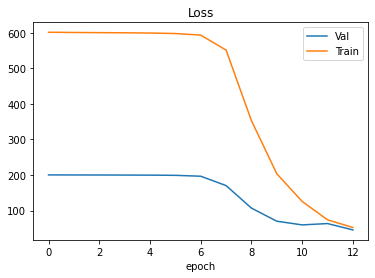

In [ ]:
plt.plot(val_loss_li, label = 'Val')
plt.plot(train_loss_li, label= 'Train')
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()


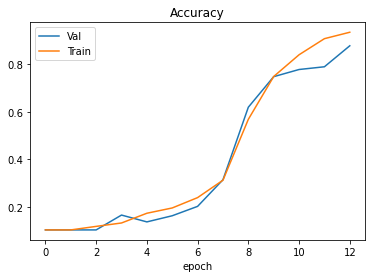

In [ ]:
plt.plot(val_acc_li, label = 'Val')
plt.plot(train_acc_li, label= 'Train')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()


## Part 2.2 - Test 

Test your machine learning model on the testing set: After finishing all the above steps, fix your hyper-parameters(learning rate, number of neurons per layer) and model parameter and test your model’s performance on the testing set. This shows the effectiveness of your model’s generalization power gained by learning. For test dataset, the performance should be more than 80% (10 Points).

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = cnnet(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(correct/total)

0.805316091954023


In [ ]:
batch = next(iter(trainloader))
yhat = cnnet(batch[0])

# !pip install torchviz
from torchviz import make_dot
make_dot(yhat, params=dict(list(cnnet.named_parameters()))).render("convnet", format="png")


In [ ]:
Image(url= "convnet.png")

## Part 2.3 - L1 Regularization. Please add L1 regularization setting in your Conv2D layer. Then, train your new model separately, and plot the training process including loss and accuracy. (10 points)

In [ ]:
cnnet = CNNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnnet.parameters(), lr=0.001, momentum=0.9)

### Added l1 loss on line 25 to 29 in the next cell

In [ ]:
train_acc_li = []
val_acc_li = []
train_loss_li = []
val_loss_li = []

l1_lambda = 0.001

for epoch in range(50):  # loop over the dataset multiple times
    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnnet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        l1_norm1 = sum(p.abs().sum() for p in cnnet.conv1.parameters())
        l1_norm2 = sum(p.abs().sum() for p in cnnet.conv2.parameters())
        
        loss = criterion(outputs, labels) 
        reg_loss = loss + l1_lambda *(l1_norm1 + l1_norm2)
        reg_loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    train_acc_li.append(correct/total)
    train_loss_li.append(train_loss)
    
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = cnnet(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss_li.append(val_loss)
    val_acc_li.append(correct/total)
            
    print('Val Acc', correct/total)
    if correct/total > .85:
        break
    
print('Finished Training')

Val Acc 0.10344827586206896
Val Acc 0.10344827586206896
Val Acc 0.10344827586206896
Val Acc 0.10775862068965517
Val Acc 0.23419540229885058
Val Acc 0.3599137931034483
Val Acc 0.6350574712643678
Val Acc 0.7385057471264368
Val Acc 0.834051724137931
Val Acc 0.8455459770114943
Val Acc 0.8785919540229885
Finished Training


In [ ]:
# Test Accuracy
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = cnnet(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(correct/total)

0.8175287356321839


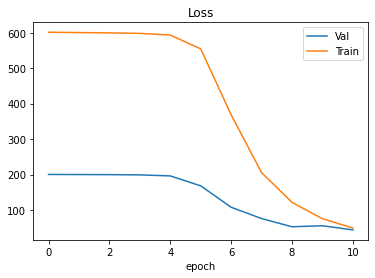

In [ ]:
plt.plot(val_loss_li, label = 'Val')
plt.plot(train_loss_li, label= 'Train')
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()


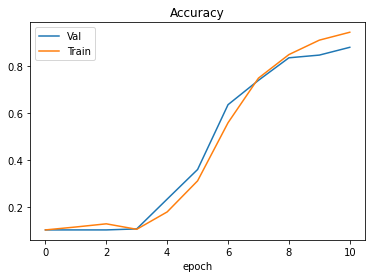

In [ ]:
plt.plot(val_acc_li, label = 'Val')
plt.plot(train_acc_li, label= 'Train')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()


## Part 2.4 - L2 Regularization. Please add L2 regularization setting in your Conv2D layer. Then, train your new model separately, and plot the training process including loss and accuracy. (10 points)

In [ ]:
cnnet = CNNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnnet.parameters(), lr=0.001, momentum=0.9)

### Added l2 loss on line 25 to 29 in the next cell

In [ ]:
train_acc_li = []
val_acc_li = []
train_loss_li = []
val_loss_li = []

l2_lambda = 0.001

for epoch in range(50):  # loop over the dataset multiple times
    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnnet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        l2_norm1 = sum(p.pow(2.0).sum() for p in cnnet.conv1.parameters())
        l2_norm2 = sum(p.pow(2.0).sum() for p in cnnet.conv2.parameters())
        
        loss = criterion(outputs, labels) 
        reg_loss = loss + l2_lambda *(l2_norm1 + l2_norm2)
        reg_loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    train_acc_li.append(correct/total)
    train_loss_li.append(train_loss)
    
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = cnnet(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss_li.append(val_loss)
    val_acc_li.append(correct/total)
            
    print('Val Acc', correct/total)
    if correct/total > .85:
        break
    
print('Finished Training')

Val Acc 0.10344827586206896
Val Acc 0.11925287356321838
Val Acc 0.10488505747126436
Val Acc 0.13793103448275862
Val Acc 0.28735632183908044
Val Acc 0.5201149425287356
Val Acc 0.7255747126436781
Val Acc 0.7780172413793104
Val Acc 0.8117816091954023
Val Acc 0.8627873563218391
Finished Training


In [ ]:
# Test Accuracy

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = cnnet(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(correct/total)

0.8505747126436781


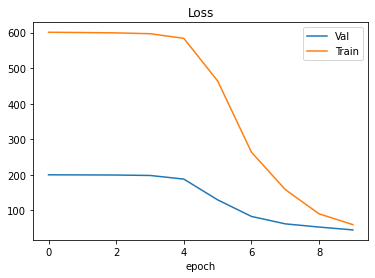

In [ ]:
plt.plot(val_loss_li, label = 'Val')
plt.plot(train_loss_li, label= 'Train')
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()


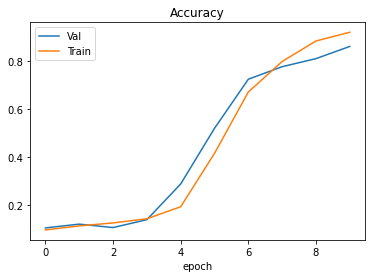

In [ ]:
plt.plot(val_acc_li, label = 'Val')
plt.plot(train_acc_li, label= 'Train')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()


## Dropout Regularization

### Added dropout on line 19 in the next cell

In [ ]:
class CNNet_drp(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(560, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = x/255
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x



In [ ]:
cnnet_drp = CNNet_drp()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnnet_drp.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_acc_li = []
val_acc_li = []
train_loss_li = []
val_loss_li = []

# l2_lambda = 0.001

for epoch in range(50):  # loop over the dataset multiple times
    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnnet_drp(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
#         l2_norm1 = sum(p.pow(2.0).sum() for p in cnnet_drp.conv1.parameters())
#         l2_norm2 = sum(p.pow(2.0).sum() for p in cnnet_drp.conv2.parameters())
        
        loss = criterion(outputs, labels) 
#         reg_loss = loss + l2_lambda *(l2_norm1 + l2_norm2)
#         reg_loss.backward()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    train_acc_li.append(correct/total)
    train_loss_li.append(train_loss)
    
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = cnnet_drp(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss_li.append(val_loss)
    val_acc_li.append(correct/total)
            
    print('Val Acc', correct/total)
    if correct/total > .85:
        break
    
print('Finished Training')

Val Acc 0.1300287356321839
Val Acc 0.14727011494252873
Val Acc 0.16522988505747127
Val Acc 0.3735632183908046
Val Acc 0.5948275862068966
Val Acc 0.6329022988505747
Val Acc 0.7586206896551724
Val Acc 0.8031609195402298
Val Acc 0.8491379310344828
Val Acc 0.8548850574712644
Finished Training


In [ ]:
# Test Accuracy

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = cnnet_drp(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(correct/total)

0.8405172413793104


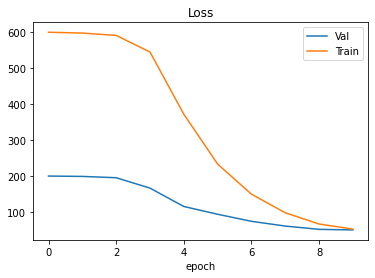

In [ ]:
plt.plot(val_loss_li, label = 'Val')
plt.plot(train_loss_li, label= 'Train')
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()


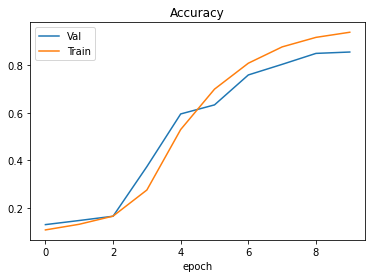

In [ ]:
plt.plot(val_acc_li, label = 'Val')
plt.plot(train_acc_li, label= 'Train')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()


## Part3 - ** only for 574 students **.
1. Fine tune the well pre-trained model, Resnet 50, with different freeze layers. 
First,  load pre-trained resnet 50 from library.
Second, Fine-tune the model to fit our project, 10-classes.
Third,  freeze different layers, plot different training process with different frozen layers (at least three different layers).

## Resnet 50

## Resnet Part 1

In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),
#     transforms.CenterCrop(size=224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225])
])

In [ ]:
training_data = CustomImageDataset(annotations_file=all_classes,
                                   img_dir='pictures/train/', 
                                   transform=transform
                                  )
val_data = CustomImageDataset(annotations_file=all_classes,
                                   img_dir='pictures/val/', 
                                   transform=transform
                                  )
test_data = CustomImageDataset(annotations_file=all_classes,
                                   img_dir='pictures/test/', 
                                   transform=transform
                                  )

batch_size = 32
trainloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

4176
1392
1392


### Freezing all parameters except last 2

In [ ]:
resnet50 = models.resnet50(pretrained=True)

for n,param in enumerate(resnet50.parameters()):
    
    print(n, param.name)
    if n < 159:
        param.requires_grad = False

0 None
1 None
2 None
3 None
4 None
5 None
6 None
7 None
8 None
9 None
10 None
11 None
12 None
13 None
14 None
15 None
16 None
17 None
18 None
19 None
20 None
21 None
22 None
23 None
24 None
25 None
26 None
27 None
28 None
29 None
30 None
31 None
32 None
33 None
34 None
35 None
36 None
37 None
38 None
39 None
40 None
41 None
42 None
43 None
44 None
45 None
46 None
47 None
48 None
49 None
50 None
51 None
52 None
53 None
54 None
55 None
56 None
57 None
58 None
59 None
60 None
61 None
62 None
63 None
64 None
65 None
66 None
67 None
68 None
69 None
70 None
71 None
72 None
73 None
74 None
75 None
76 None
77 None
78 None
79 None
80 None
81 None
82 None
83 None
84 None
85 None
86 None
87 None
88 None
89 None
90 None
91 None
92 None
93 None
94 None
95 None
96 None
97 None
98 None
99 None
100 None
101 None
102 None
103 None
104 None
105 None
106 None
107 None
108 None
109 None
110 None
111 None
112 None
113 None
114 None
115 None
116 None
117 None
118 None
119 None
120 None
121 None
122 None
123

In [ ]:
fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
        nn.Linear(fc_inputs, 224),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(224, 10),
        nn.LogSoftmax(dim=1) # For using NLLLoss()
)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
resnet50 = resnet50.to(device)

In [ ]:
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters())

In [ ]:
train_acc_li = []
val_acc_li = []
train_loss_li = []
val_loss_li = []
for epoch in range(50):
#     resnet50.train()
    correct = 0
    total = 0
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs = inputs.float()
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = resnet50(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_acc_li.append(correct/total)
    train_loss_li.append(train_loss)
    
    # Validation
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        resnet50.eval()
        for j, (inputs, labels) in enumerate(valloader):
            inputs = inputs.float()
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = resnet50(inputs)
            loss = loss_func(outputs, labels)
            val_loss += loss.item()
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            total += labels.size(0)
            correct += sum(correct_counts).item()
            
            
#     print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
    val_loss_li.append(val_loss)
    val_acc_li.append(correct/total)
    print(correct/total)
    if (correct/total) > 0.8:
        break
    

0.7126436781609196
0.8067528735632183


In [ ]:
p.abs()

tensor([[[[4.9247e-02, 1.0304e-01, 5.8713e-02, 3.0112e-02, 8.2252e-02],
          [2.0121e-02, 1.6434e-01, 1.7461e-01, 3.0119e-02, 4.6782e-02],
          [5.0876e-02, 2.4193e-01, 9.3872e-02, 6.1807e-02, 4.1038e-02],
          [2.3701e-01, 2.3057e-01, 2.0514e-01, 1.5106e-01, 2.1049e-01],
          [1.8927e-02, 1.1398e-01, 2.4318e-01, 9.0140e-02, 1.6017e-01]],

         [[1.2069e-01, 1.2798e-01, 1.1781e-01, 2.7361e-02, 7.3076e-02],
          [3.1376e-02, 1.1581e-01, 1.6047e-01, 1.0577e-01, 8.1320e-02],
          [2.1194e-01, 2.3398e-01, 2.1429e-01, 6.6884e-02, 1.4869e-01],
          [1.6628e-01, 8.5983e-02, 1.9129e-01, 1.6009e-01, 3.9445e-03],
          [1.7854e-01, 8.4651e-02, 2.0117e-01, 1.0375e-01, 1.5770e-01]],

         [[1.0302e-02, 2.2685e-03, 2.3851e-02, 9.4197e-03, 8.4502e-02],
          [8.0518e-02, 1.7064e-02, 8.4113e-02, 2.4610e-02, 4.2443e-02],
          [1.9555e-03, 1.7293e-02, 8.2497e-02, 6.7926e-02, 3.2318e-02],
          [4.2914e-02, 4.0805e-02, 6.1266e-02, 5.8273e-03, 2

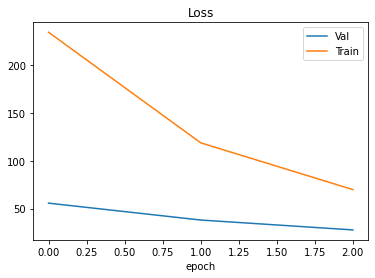

In [ ]:
plt.plot(val_loss_li, label = 'Val')
plt.plot(train_loss_li, label= 'Train')
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()


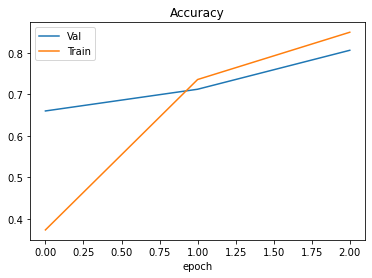

In [ ]:
plt.plot(val_acc_li, label = 'Val')
plt.plot(train_acc_li, label= 'Train')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()


## Resnet Part 2

In [ ]:
transform = transforms.Compose([
    transforms.Resize(112),
#     transforms.CenterCrop(size=224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225])
])

In [ ]:
training_data = CustomImageDataset(annotations_file=all_classes,
                                   img_dir='pictures/train/', 
                                   transform=transform
                                  )
val_data = CustomImageDataset(annotations_file=all_classes,
                                   img_dir='pictures/val/', 
                                   transform=transform
                                  )
test_data = CustomImageDataset(annotations_file=all_classes,
                                   img_dir='pictures/test/', 
                                   transform=transform
                                  )

batch_size = 32
trainloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

4176
1392
1392


### Freezing all parameters except last

In [ ]:
resnet50 = models.resnet50(pretrained=True)

for n,param in enumerate(resnet50.parameters()):
    
#     print(n, param.name)
    if n < 160:
        param.requires_grad = False

In [ ]:
fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
        nn.Linear(fc_inputs, 224),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(224, 10),
        nn.LogSoftmax(dim=1) # For using NLLLoss()
)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
resnet50 = resnet50.to(device)

In [ ]:
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters())

In [ ]:
train_acc_li = []
val_acc_li = []
train_loss_li = []
val_loss_li = []
for epoch in range(50):
#     resnet50.train()
    correct = 0
    total = 0
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs = inputs.float()
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = resnet50(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_acc_li.append(correct/total)
    train_loss_li.append(train_loss)
    
    # Validation
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        resnet50.eval()
        for j, (inputs, labels) in enumerate(valloader):
            inputs = inputs.float()
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = resnet50(inputs)
            loss = loss_func(outputs, labels)
            val_loss += loss.item()
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            total += labels.size(0)
            correct += sum(correct_counts).item()
            
            
#     print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
    val_loss_li.append(val_loss)
    val_acc_li.append(correct/total)
    print(correct/total)
    if (correct/total) > 0.8:
        break
    

0.7133620689655172
0.7327586206896551
0.7564655172413793
0.7406609195402298
0.7227011494252874
0.7492816091954023
0.7665229885057471
0.7535919540229885
0.7593390804597702
0.7665229885057471


Traceback (most recent call last):
  File "/home/nabeel/anaconda3/envs/t2/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/nabeel/anaconda3/envs/t2/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/nabeel/anaconda3/envs/t2/lib/python3.9/multiprocessing/connection.py", line 416, in _send_bytes
    self._send(header + buf)
  File "/home/nabeel/anaconda3/envs/t2/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

Interrupted the above cell after 10 epochs, as it was taking a lot of time

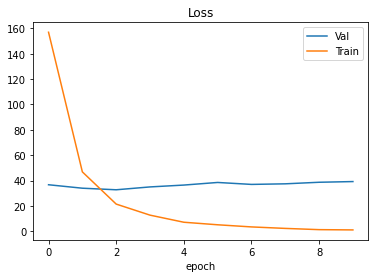

In [ ]:
plt.plot(val_loss_li, label = 'Val')
plt.plot(train_loss_li, label= 'Train')
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()


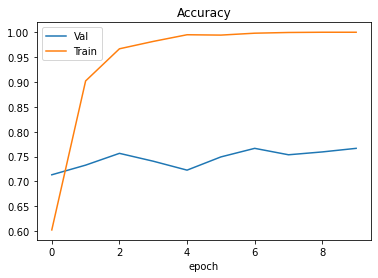

In [ ]:
plt.plot(val_acc_li, label = 'Val')
plt.plot(train_acc_li, label= 'Train')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()


## Resnet Part 3

In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),
#     transforms.CenterCrop(size=224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225])
])

In [ ]:
training_data = CustomImageDataset(annotations_file=all_classes,
                                   img_dir='pictures/train/', 
                                   transform=transform
                                  )
val_data = CustomImageDataset(annotations_file=all_classes,
                                   img_dir='pictures/val/', 
                                   transform=transform
                                  )
test_data = CustomImageDataset(annotations_file=all_classes,
                                   img_dir='pictures/test/', 
                                   transform=transform
                                  )

batch_size = 32
trainloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

4176
1392
1392


### Freezing all parameters except last 3

In [ ]:
resnet50 = models.resnet50(pretrained=True)

for n,param in enumerate(resnet50.parameters()):
    
    print(n, param.name)
    if n < 158:
        param.requires_grad = False

0 None
1 None
2 None
3 None
4 None
5 None
6 None
7 None
8 None
9 None
10 None
11 None
12 None
13 None
14 None
15 None
16 None
17 None
18 None
19 None
20 None
21 None
22 None
23 None
24 None
25 None
26 None
27 None
28 None
29 None
30 None
31 None
32 None
33 None
34 None
35 None
36 None
37 None
38 None
39 None
40 None
41 None
42 None
43 None
44 None
45 None
46 None
47 None
48 None
49 None
50 None
51 None
52 None
53 None
54 None
55 None
56 None
57 None
58 None
59 None
60 None
61 None
62 None
63 None
64 None
65 None
66 None
67 None
68 None
69 None
70 None
71 None
72 None
73 None
74 None
75 None
76 None
77 None
78 None
79 None
80 None
81 None
82 None
83 None
84 None
85 None
86 None
87 None
88 None
89 None
90 None
91 None
92 None
93 None
94 None
95 None
96 None
97 None
98 None
99 None
100 None
101 None
102 None
103 None
104 None
105 None
106 None
107 None
108 None
109 None
110 None
111 None
112 None
113 None
114 None
115 None
116 None
117 None
118 None
119 None
120 None
121 None
122 None
123

In [ ]:
fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
        nn.Linear(fc_inputs, 224),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(224, 10),
        nn.LogSoftmax(dim=1) # For using NLLLoss()
)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
resnet50 = resnet50.to(device)

In [ ]:
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters())

In [ ]:
train_acc_li = []
val_acc_li = []
train_loss_li = []
val_loss_li = []
for epoch in range(10):
#     resnet50.train()
    correct = 0
    total = 0
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs = inputs.float()
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = resnet50(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_acc_li.append(correct/total)
    train_loss_li.append(train_loss)
    
    # Validation
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        resnet50.eval()
        for j, (inputs, labels) in enumerate(valloader):
            inputs = inputs.float()
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = resnet50(inputs)
            loss = loss_func(outputs, labels)
            val_loss += loss.item()
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            total += labels.size(0)
            correct += sum(correct_counts).item()
            
            
#     print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
    val_loss_li.append(val_loss)
    val_acc_li.append(correct/total)
    print(correct/total)
    if (correct/total) > 0.8:
        break
    

0.5912356321839081
0.7622126436781609
0.7765804597701149
0.771551724137931
0.8038793103448276


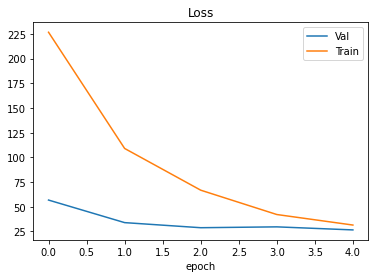

In [ ]:
plt.plot(val_loss_li, label = 'Val')
plt.plot(train_loss_li, label= 'Train')
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()


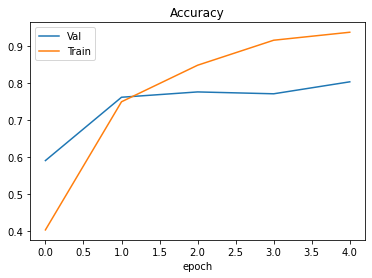

In [ ]:
plt.plot(val_acc_li, label = 'Val')
plt.plot(train_acc_li, label= 'Train')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()
